In [18]:
import os
import cv2
import torch
import json
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import custom_utils.data_conversion as data_conversion
import custom_utils.depth_anything_interface as depth_anything_interface

MODEL_TYPE = "metric"
DATASET = "hypersim"
ENCODER = "vitl"
DATAFILE = "/scratchdata/stationary_2L"
CAMERA_JSON = "/scratchdata/gemini_2l.json"
MODEL_PATH = f"/scratchdata/depth_anything_v2_metric_{DATASET}_{ENCODER}.pth"
with open(CAMERA_JSON, 'r') as f:
    CAMERA_DATA = json.load(f)
FRAME_INDEX = 0
SQUARE_SIZE = 24 #mm
CHECKERBOARD = (8,6)
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
MODEL = depth_anything_interface.get_model(DEVICE, MODEL_PATH, model_type = MODEL_TYPE, encoder=ENCODER)

# Open bag file
bag_file_path = os.path.join(DATAFILE, "raw.bag")
bag = rosbag.Bag(bag_file_path)

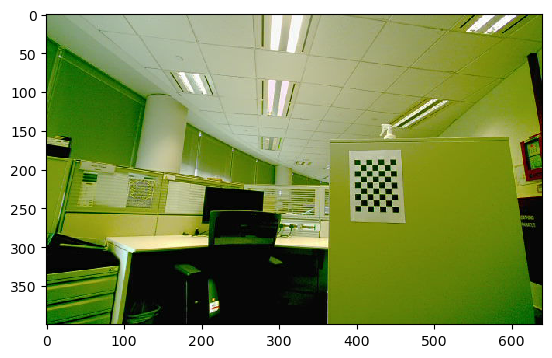

In [19]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    if wait == FRAME_INDEX:
        img = data_conversion.topic_to_image(msg)
        break
    wait += 1

plt.imshow(img)

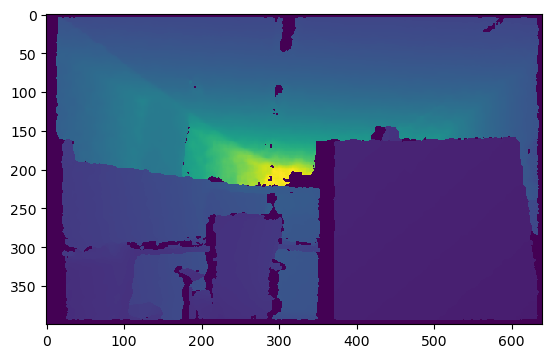

In [20]:
wait = 0

for topic, msg, t in bag.read_messages(topics=["/camera/depth/image_raw"]):
    if wait == FRAME_INDEX:
        depth = data_conversion.topic_to_depth(msg, CAMERA_DATA)
        break
    wait += 1

plt.imshow(depth)

[0.52542576]
R2: 0.9679724100744814


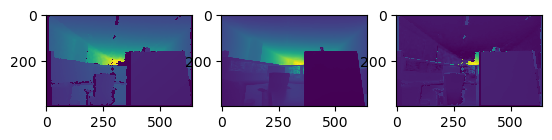

In [21]:
est_depth = MODEL.infer_image(np.array(img)) # HxW raw depth map in numpy

pred_depth, popt = depth_anything_interface.get_pred_depth(depth, est_depth, CAMERA_DATA, depth_anything_interface.estimated_metric_depth_model, verbose=True)

fig, axs = plt.subplots(1, 3)

depth_normalised = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))
pred_normalised = (pred_depth - np.min(pred_depth)) / (np.max(pred_depth) - np.min(pred_depth))

axs[0].imshow(depth_normalised)
axs[1].imshow(pred_normalised)
diff = abs(depth_normalised - pred_normalised)
axs[2].imshow(diff)

(0, 10)

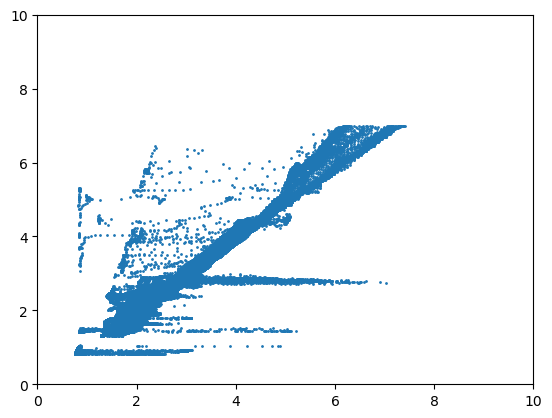

In [22]:
depth_flatten = depth.flatten()
est_depth_flatten = est_depth.flatten()
est_depth_flatten = est_depth_flatten[(depth_flatten>=CAMERA_DATA["min_acc_range"]) & (depth_flatten<=CAMERA_DATA["max_acc_range"])]
depth_flatten = depth_flatten[(depth_flatten>=CAMERA_DATA["min_acc_range"]) & (depth_flatten<=CAMERA_DATA["max_acc_range"])]

plt.scatter(depth_anything_interface.estimated_metric_depth_model(est_depth_flatten, *popt), depth_flatten, s=1)
#Set axis limits to be the same
plt.xlim([0, 10])
plt.ylim([0, 10])

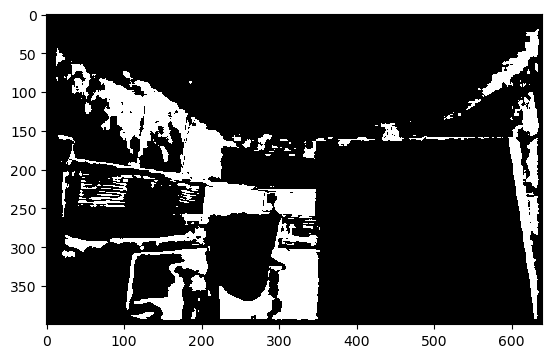

In [66]:
pixel_index = np.array(np.meshgrid(np.arange(depth.shape[0]), np.arange(depth.shape[1]))).T.reshape(-1, 2)
depth_flatten = depth.flatten()
est_depth_flatten = est_depth.flatten()
pixel_index = pixel_index[(depth_flatten>=CAMERA_DATA["min_acc_range"]) & (depth_flatten<=CAMERA_DATA["max_acc_range"])]
est_depth_flatten = est_depth_flatten[(depth_flatten>=CAMERA_DATA["min_acc_range"]) & (depth_flatten<=CAMERA_DATA["max_acc_range"])]
depth_flatten = depth_flatten[(depth_flatten>=CAMERA_DATA["min_acc_range"]) & (depth_flatten<=CAMERA_DATA["max_acc_range"])]

diff = abs(depth_flatten - depth_anything_interface.estimated_metric_depth_model(est_depth_flatten, *popt))

pixel_index = pixel_index[diff > 0.2]

mask = np.zeros_like(img)

mask[pixel_index[:,0], pixel_index[:,1], :] = 255

plt.imshow(mask)

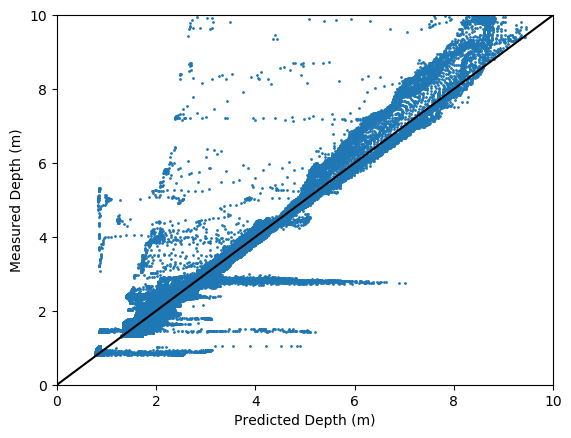

In [24]:
depth_flatten = depth.flatten()
est_depth_flatten = est_depth.flatten()
est_depth_flatten = est_depth_flatten[depth_flatten!=CAMERA_DATA["min_range"]]
depth_flatten = depth_flatten[depth_flatten!=CAMERA_DATA["min_range"]]
#est_depth_flatten = est_depth_flatten[depth_flatten>=CAMERA_DATA["min_acc_range"]]
#depth_flatten = depth_flatten[depth_flatten>=CAMERA_DATA["min_acc_range"]]
#est_depth_flatten = est_depth_flatten[depth_flatten<=CAMERA_DATA["max_acc_range"]]
#depth_flatten = depth_flatten[depth_flatten<=CAMERA_DATA["max_acc_range"]]

plt.scatter(depth_anything_interface.estimated_metric_depth_model(est_depth_flatten, *popt), depth_flatten, s=1)
#Set axis limits to be the same
plt.xlim([0, 10])
plt.ylim([0, 10])

plt.xlabel("Predicted Depth (m)")
plt.ylabel("Measured Depth (m)")

#  Draw a y=x line
plt.plot([0, 10], [0, 10], 'k-')

In [25]:
for topic, msg, t in bag.read_messages(topics=["/camera/color/camera_info"]):
    print(msg)
    D = np.array(msg.D)
    K = np.array(msg.K).reshape((3, 3))
    P = np.array(msg.P).reshape((3, 4))
    R = np.array(msg.R).reshape((3, 3))
    height = msg.height
    width = msg.width
    distortion_model = msg.distortion_model
    break

header: 
  seq: 134
  stamp: 
    secs: 1724131724
    nsecs: 148440064
  frame_id: "camera_color_optical_frame"
height: 400
width: 640
distortion_model: "rational_polynomial"
D: [-1.0653736591339111, 0.47793787717819214, -0.000639380537904799, 0.0004882288631051779, -0.02852124534547329, -1.0467253923416138, 0.4518430233001709, -0.018296383321285248]
K: [306.4570007324219, 0.0, 319.01312255859375, 0.0, 306.4668884277344, 197.51637268066406, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [306.4570007324219, 0.0, 319.01312255859375, 0.0, 0.0, 306.4668884277344, 197.51637268066406, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 0
binning_y: 0
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: False


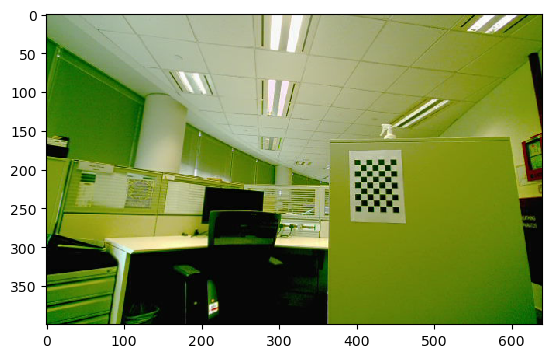

In [26]:
# Undistort image
img_undistorted = cv2.undistort(img, K, D, P)

plt.imshow(img_undistorted)

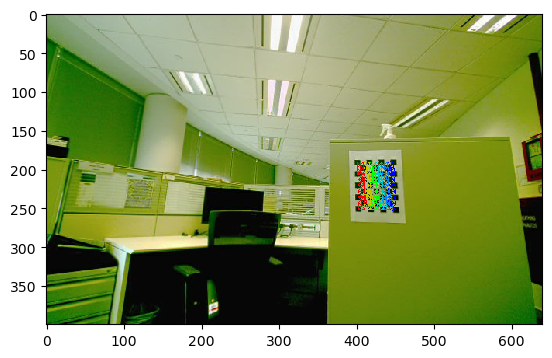

In [27]:
#Estimate distance of checkerboard
# Load camera matrix
ret, corners = cv2.findChessboardCorners(
    img_undistorted, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH)
if ret:
    fnl = cv2.drawChessboardCorners(np.float32(img_undistorted/255.0), CHECKERBOARD, corners, ret)
    plt.imshow(fnl)
else:
    print("No Checkerboard Found")
    plt.imshow(res)


In [28]:
# Prepare the object points (3D points in real world space)
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= SQUARE_SIZE  # Scale by the size of the squares

ret, rvec, tvec = cv2.solvePnP(objp, corners, K, D)
rotation_matrix, _ = cv2.Rodrigues(rvec)
transformation_matrix = np.hstack((rotation_matrix, tvec))
transformation_matrix = np.vstack((transformation_matrix, [0, 0, 0, 1]))

In [29]:
# Find norm distance between objp and tvec

camera_estimated_depth = []
for p in objp:
    camera_estimated_depth.append(np.linalg.norm(p - tvec.reshape(3)))

camera_estimated_depth = np.array(camera_estimated_depth) / 1000

print(camera_estimated_depth)

[1.05208674 1.04322628 1.03484668 1.02695969 1.01957676 1.01270892
 1.00636669 1.00056009 1.05252936 1.04367266 1.03529667 1.02741314
 1.02003349 1.01316874 1.00682941 1.00102549 1.05351867 1.04467036
 1.03630243 1.02842661 1.02105429 1.01419645 1.00786358 1.00206565
 1.05505314 1.04621781 1.03786236 1.02999847 1.02263748 1.01579032
 1.00946746 1.00367879 1.0571304  1.04831257 1.03997395 1.03212615
 1.02478044 1.0179477  1.01163832 1.00586215 1.05974724 1.05095137
 1.04263386 1.03480623 1.02747968 1.02066501 1.01437253 1.00861202]


In [30]:
original_depth = data_conversion.interpolate_depth(depth,corners.reshape(-1, 2))
print(original_depth)

[0.988      0.9806796  0.97791779 0.97402046 0.96646159 0.96399782
 0.95966025 0.956      0.99136861 0.98573017 0.98184873 0.976
 0.97370998 0.96795661 0.9642308  0.96013744 0.99538939 0.99108148
 0.98398789 0.98       0.976      0.972      0.97010925 0.964
 0.99868946 0.99446551 0.99136606 0.98695357 0.98134052 0.97649829
 0.97453047 0.97035066 1.0040408  1.0006311  0.99643213 0.99078998
 0.98616014 0.98208919 0.97893674 0.97564756 1.00980105 1.005
 1.00109639 0.99504599 0.99185036 0.98840948 0.984      0.97917363]


Mean error:  0.04538661179912693
Max error:  0.06408673712843882
Standard deviation:  0.008846635329388567


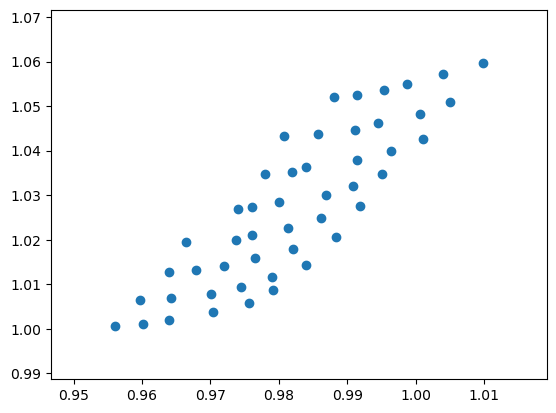

In [31]:
error = np.abs(original_depth - camera_estimated_depth)
print("Mean error: ", np.mean(error))
print("Max error: ", np.max(error))
print("Standard deviation: ", np.std(error))

plt.scatter(original_depth, camera_estimated_depth)

In [32]:
post_processing_depth = data_conversion.interpolate_depth(pred_depth,corners.reshape(-1, 2))
print(post_processing_depth)

[0.82893074 0.82499212 0.82703224 0.82257165 0.81628177 0.81700433
 0.81501863 0.81192871 0.8287747  0.8241866  0.82195105 0.81690369
 0.81521437 0.81445735 0.81235589 0.80986556 0.82879758 0.82515719
 0.82514856 0.82111417 0.81320124 0.81506868 0.81258994 0.80994884
 0.82934192 0.82334058 0.82446446 0.81786039 0.81322491 0.81343985
 0.81015225 0.80895252 0.82916951 0.82557136 0.82344862 0.8212813
 0.81628875 0.8145475  0.81243176 0.80900848 0.83690066 0.83038332
 0.83013752 0.82421244 0.82315492 0.8197632  0.81602494 0.81307327]


Mean error:  0.2078640474850236
Max error:  0.2279608851903112
Standard deviation:  0.010772107533135393


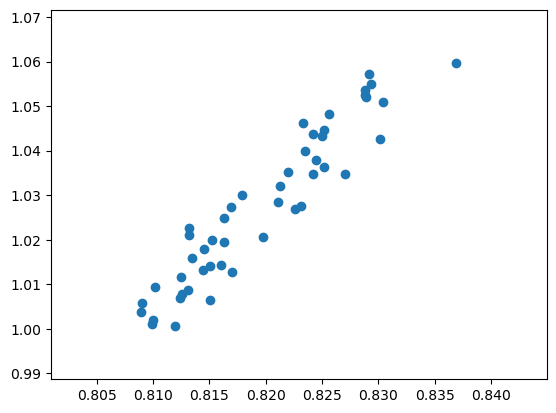

In [33]:
error = np.abs(post_processing_depth - camera_estimated_depth)
print("Mean error: ", np.mean(error))
print("Max error: ", np.max(error))
print("Standard deviation: ", np.std(error))

plt.scatter(post_processing_depth, camera_estimated_depth)